In [5]:
import os
import tarfile
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision.transforms as T
from torchvision import models
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url

from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
SEED = 42
torch.manual_seed(SEED)

# Download Data

In [7]:
DOWNLOAD_URL = "https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz"
download_url(DOWNLOAD_URL, ".")

Using downloaded and verified file: ./oxford-iiit-pet.tgz


In [8]:
with tarfile.open("./oxford-iiit-pet.tgz", "r:gz") as tar:
  tar.extractall(path="./data")

In [9]:
DATA_DIR = "./data/oxford-iiit-pet/images"

files = os.listdir(DATA_DIR)
files[:5]

['american_bulldog_90.jpg',
 'havanese_50.jpg',
 'pomeranian_16.jpg',
 'english_cocker_spaniel_112.jpg',
 'scottish_terrier_42.jpg']

# Create Custom Dataset

In [10]:
def parse_breed(file_name):
  splitted = file_name.split("_")
  return " ".join(splitted[:-1])

parse_breed(files[123])

'chihuahua'

In [11]:
from PIL import Image

def open_image(path):
  with open(path, "rb") as f:
    img = Image.open(f)
    return img.convert('RGB')

In [12]:
from torch.utils.data import Dataset

class PetsDataset(Dataset):
  def __init__(self, root, transform):
    super().__init__()

    self.root = root
    self.transform = transform
    self.files = [fname for fname in os.listdir(root) if fname.endswith(".jpg")]
    self.classes = list(set(parse_breed(fname) for fname in self.files))

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    fname = self.files[idx]
    fpath = os.path.join(self.root, fname)
    image = self.transform(open_image(fpath))
    class_index = self.classes.index(parse_breed(fname))
    return image, class_index


In [13]:
image_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = PetsDataset(DATA_DIR, transform=T.Compose([T.Resize(image_size),
                                                     T.Pad(8, padding_mode="reflect"),
                                                     T.RandomCrop(image_size),
                                                     T.ToTensor(),
                                                     T.Normalize(*imagenet_stats)]))

In [14]:
len(dataset)

7390

In [15]:
def denormalize(images, means, stds):
  if len(images.shape) == 3:
    images = images.unsqueeze(0)

  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)

  return images * stds + means

def show_image(image_tensor, label):
  print("Label: {} ({})".format(dataset.classes[label], label))
  image_tensor = denormalize(image_tensor, *imagenet_stats)[0].permute(1, 2, 0)
  plt.imshow(image_tensor)
  plt.axis("off")

Label: american bulldog (14)


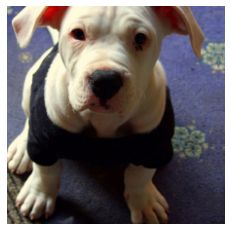

In [16]:
show_image(*dataset[0])

# Training and Validation Sets, DataLoader

In [17]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(6651, 739)

In [18]:
BATCH_SIZE = 256

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val_ds, BATCH_SIZE, pin_memory=True, num_workers=2)

In [19]:
def show_batch(dl):
  for images, _ in dl:
    images = denormalize(images[:64], *imagenet_stats)
    figure, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

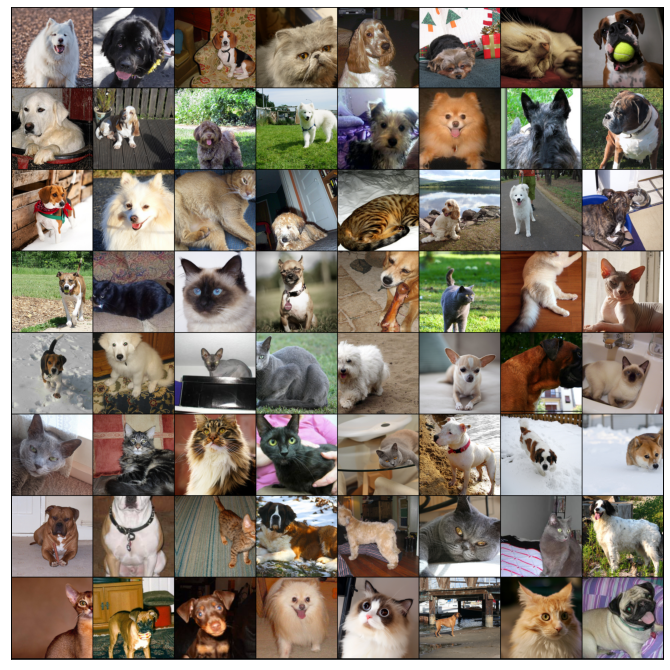

In [20]:
show_batch(train_dl)

In [21]:
def get_device():
  """Pick GPU if GPU is available, else pick CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")


def to_device(data, device):
  """Move Tensors to specified device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)


class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    """Returns the number of batches in the dataloader"""
    return len(self.dl)

In [22]:
device = get_device()
device

device(type='cuda')

In [23]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)

# Model

In [24]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f} val_Loss: {:.4f}, val_Acc: {:.4f}".format(
        epoch,
        result["lrs"][-1],
        result["train_loss"],
        result["val_loss"],
        result["val_acc"]))

In [25]:
models.resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
class PetsModel(ImageClassificationBase):
  def __init__(self, num_classes, pretrained):
    super().__init__()
    self.network = models.resnet34(pretrained=pretrained)
    self.network.fc = nn.Linear(self.network.fc.in_features, num_classes, bias=True)

  def forward(self, xb):
    return self.network(xb)


In [27]:
len(dataset.classes)

37

In [28]:
model = PetsModel(len(dataset.classes), True)
model = to_device(model, device)

# Training

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)


def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]

  
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=epochs, 
                                              steps_per_epoch=len(train_loader))
  
  for epoch in range(epochs):
    # Training Step
    model.train()
    train_losses = []
    lrs = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Clip the Gradient
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record and Update the Learning Rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation Step
    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["lrs"] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [30]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.01205144077539444, 'val_loss': 3.8696799278259277}]

In [31]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [32]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                         weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00382, train_loss: 1.1174 val_Loss: 13.7594, val_Acc: 0.0741


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00934, train_loss: 1.7861 val_Loss: 4.2097, val_Acc: 0.1041


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00972, train_loss: 1.4934 val_Loss: 3.0329, val_Acc: 0.2185


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00812, train_loss: 1.0377 val_Loss: 1.2629, val_Acc: 0.6439


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00556, train_loss: 0.6809 val_Loss: 1.1908, val_Acc: 0.6457


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00283, train_loss: 0.4267 val_Loss: 0.8424, val_Acc: 0.7478


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00077, train_loss: 0.2593 val_Loss: 0.5828, val_Acc: 0.8135


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00000, train_loss: 0.1592 val_Loss: 0.5589, val_Acc: 0.8293
CPU times: user 2min 55s, sys: 2min 41s, total: 5min 37s
Wall time: 10min 21s


# Training Model From Scratch

In [33]:
model2 = PetsModel(len(dataset.classes), False)
model2 = to_device(model2, device)

In [34]:
history2 = [evaluate(model2, val_loader)]
history2

[{'val_acc': 0.02443557232618332, 'val_loss': 84.95420837402344}]

In [35]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_loader, val_loader, 
                         weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00382, train_loss: 3.4971 val_Loss: 118.5438, val_Acc: 0.0226


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00934, train_loss: 3.3803 val_Loss: 13.7616, val_Acc: 0.0531


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.00972, train_loss: 3.2036 val_Loss: 3.6778, val_Acc: 0.0858


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00812, train_loss: 3.0226 val_Loss: 3.5462, val_Acc: 0.0826


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00556, train_loss: 2.8276 val_Loss: 3.0923, val_Acc: 0.1520


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00283, train_loss: 2.5883 val_Loss: 2.8058, val_Acc: 0.2026


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00077, train_loss: 2.3095 val_Loss: 2.6424, val_Acc: 0.2577


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00000, train_loss: 2.1261 val_Loss: 2.3513, val_Acc: 0.3315
CPU times: user 2min 56s, sys: 2min 42s, total: 5min 38s
Wall time: 10min 20s


In [36]:
dir(models)

['AlexNet',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 're

In [35]:
# Save the Experiment